In [1]:
#import necessary libraries KERAS, MATPLOTLIB, NUMPY, PANDAS

import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

C:\tools\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import training and test set

train = pd.read_csv('../Kaggle data/Toxic comments/train.csv')
test = pd.read_csv('../Kaggle data/Toxic comments/test.csv')

In [3]:
train.head()

#Not that dependent values are together with independent, split up into x and y values for training later.

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#Check for nulls in data
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [7]:
########################## DO MORE PREPROCESSING IF NOT ACCURATE RESULTS #############################

In [8]:
#Split training into X and Y values, dependent from independet. 

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y_train = train[list_classes].values

X_train = train["comment_text"]
X_test = test["comment_text"]

In [9]:
# Tokenize comments, separate sentences into separate words, tokenize them, ex: "THE" becomes token 1
max_features = 20000
tokenizer = Tokenizer(num_words=max_features, lower=True, filters ='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split = ' ')
tokenizer.fit_on_texts(list(X_train))

# Now reconstruct sequences with the tokens at their position ex: "THE APPLE" becomes [1,252]
X_train_TOK = tokenizer.texts_to_sequences(X_train)
X_test_TOK = tokenizer.texts_to_sequences(X_test)

[(487246, 'the'), (296510, 'to')]


<Container object of 100 artists>

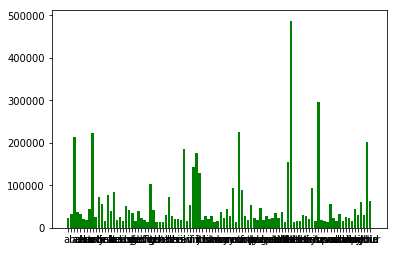

In [10]:
#Check counted words
dict_ = tokenizer.word_counts 

#Check index of words
#tokenizer.word_index

sorted_d = sorted((value, key) for (key,value) in dict_.items())
sorted_d = sorted(sorted_d, reverse=True)

#print(sorted_d[:100])
sorted_d = sorted_d[:100]
print(sorted_d[:2])

values = [k for k,v in sorted_d]
keys = [v for k,v in sorted_d]

#Do a word count frewuency histogram....::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::............::::::::::::::
plt.bar(keys, values,color='g')
#Comment to self :::..... remove "\n" when tokenizing, it's disrupting the data.


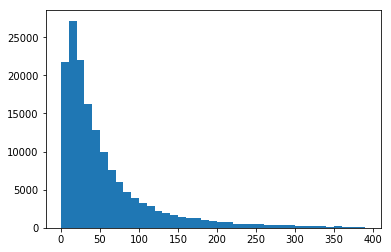

In [11]:
#Find length of sentences frewuency histogram
Nr_of_words = [len(one_comment) for one_comment in X_train_TOK]
plt.hist(Nr_of_words, bins=np.arange(0,400,10), label = "Length of comment")
plt.show()

In [12]:
#Since we want to train our model on neural netwrok we have to make sure all tokenized sentences have the same length,
# longer sentences becomes smaller than a maxlength and small sentences mecomes longer , filling empty token positions with 0
# ex:  "The apple" = [1, 252] becomes [1,252,0,0,0,0]  and longer such as " The apple doesn't fall far from the tree" might neeed to be cut into 2 sentences if longer than maxlength

#Maximum length to 200 because it captures most words in diagram above.
maxlen = 200
X_train_TOK_PAD = pad_sequences(X_train_TOK, maxlen=maxlen)
X_test_TOK_PAD = pad_sequences(X_test_TOK, maxlen=maxlen)

In [13]:
############################################### MODEL ################################################
# USING KERAS LAYERS

# INPUT LATER
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

# EMBEDDED LAYER, can tune embed_size
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# LSTM LAYER
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

# MAXPOOLING LAYER
x = GlobalMaxPool1D()(x)

# DROPOUT
x = Dropout(0.1)(x)

# DENSE
x = Dense(50, activation="relu")(x)

# DROPOUT
x = Dropout(0.1)(x)

# DENSE
x = Dense(6, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [14]:
# TESTING MODEL ON DATA, Can tune batch_size and epochs

batch_size = 32
epochs = 2
model.fit(X_train_TOK_PAD,Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 1656s 12ms/step - loss: 0.0747 - acc: 0.9762 - val_loss: 0.0516 - val_acc: 0.9813
Epoch 2/2
143613/143613 [==============================] - 1610s 11ms/step - loss: 0.0467 - acc: 0.9828 - val_loss: 0.0489 - val_acc: 0.9820


In [18]:
# TESTING IT'S ACCURACY ON TEST SET.

results = model.predict(X_test_TOK_PAD, batch_size=batch_size, verbose=0, steps=None)

%store results






Stored 'results' (ndarray)


In [ ]:
#%store -r a
#print a # Should print 1

In [21]:
results

array([[9.97168362e-01, 4.25440818e-01, 9.61451352e-01, 7.12875053e-02,
        9.07640338e-01, 2.22383633e-01],
       [7.15996255e-04, 1.34422010e-06, 1.29436914e-04, 2.20217271e-06,
        1.07080879e-04, 4.93360458e-05],
       [4.43258695e-03, 9.93536923e-06, 7.17890216e-04, 1.87007263e-05,
        7.75729131e-04, 2.37241606e-04],
       ...,
       [9.01248772e-04, 3.79593160e-07, 1.13626695e-04, 1.19457241e-06,
        9.34765776e-05, 4.37552699e-05],
       [1.07798050e-03, 8.93298022e-07, 1.75396854e-04, 2.21294317e-06,
        1.15290219e-04, 7.09676169e-05],
       [9.02160347e-01, 1.70694459e-02, 5.43868542e-01, 9.73678473e-03,
        5.20460486e-01, 5.27123660e-02]], dtype=float32)

In [23]:
test_labels = pd.read_csv('../Kaggle data/Toxic comments/test_labels.csv')

test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________